<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/RecercaExtra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cerca de la característica 'Pel'

En aquest fitxer cercarem quines posicions dels vectors de característiques de les imatges pot tenir a veure amb la caracterísitica 'pel'. Per fer-ho compararem vectors de imatges que visiblement tenen pel amb altres que no en tenen. Les comparacions es faran dins la mateixa classe, és a dir, compararem vectors pertanyents a la mateixa malaltia.

Com que només hem estat capaços de trobar un nombre significatiu d'imatges amb pel de les malalties 'mel' i 'nv' realitzarem l'estudi sobre aquestes. Cercarem les posicions que a ambdues classes coincideixen en el fet de tenir influència sobre la característica 'pel'.

In [ ]:
import torch
import cv2
import csv
import random
import numpy as np
import ast
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json
import sys
import ast
import shutil

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'
DOWNLOAD = False
PUT = False
RUN = 22

drive.mount('/content/drive')

TESTING_FEATURES_FILE = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/Features/testing_features.txt'
TRAINING_FEATURES_FILE = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/Features/training_features.txt'
HAIRIMG = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/HairFeature/'
NOHAIRIMG =  '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/NoHairFeature/'
FOLDERS = ['nv','bcc','bkl','akiec','vasc','mel','df']

if PUT:
  if os.path.exists(HAIRIMG):
      shutil.rmtree(HAIRIMG)
  if os.path.exists(NOHAIRIMG):
      shutil.rmtree(NOHAIRIMG)

  os.makedirs(HAIRIMG,exist_ok=True)
  os.makedirs(NOHAIRIMG,exist_ok=True)

  for i in FOLDERS:
    os.makedirs(HAIRIMG+i+'/',exist_ok=True)
    os.makedirs(NOHAIRIMG+i+'/',exist_ok=True)



if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')


IMAGE_PATHS1 = glob('/content/sample_data/HAM10000_images_part_1/*.jpg')
IMAGE_PATHS2 = glob('/content/sample_data/HAM10000_images_part_2/*.jpg')
IMAGE_PATHS3 = glob('/content/sample_data/ham10000_images_part_1/*.jpg')
IMAGE_PATHS4 = glob('/content/sample_data/ham10000_images_part_2/*.jpg')
IMAGE_PATHS = IMAGE_PATHS3
# PATH_TRAINING_DISTANCES = "/content/drive/MyDrive/Features/Embeddings/embeddings_pesos_resnet152multiclass_3.pt.txt" #embeddings training
# DISTANCES_IMAGES = "/content/drive/MyDrive/Features/Dist/1/distances.txt" #distàncies de totes les imatges de test

IMG_PATH = '/content/sample_data/HAM10000_images_part_2/'

hair_img_numbers = [27790,27010,25415,25606,28732,26193,26947,27970,24891,26315,26392,27199,26127,27970,24891,26315,26392,27199,26127,26303,29097,25282,28642,27295,28424,26184,24779,26998,24342,26615
               ,26651,28921, 28777, 26292, 25746, 25216, 24803, 24411, 26879, 26286, 25746, 25526, 25466,33886,33569,30693,30643,30768,30426,34235,30064,30624,32942,33738,34297,
               33337,33067,31057,30178,31172,31178,34085,31775,31096,30882,33374,33450,32266,29954,33380,29937,29780,
               30353,30920,34295,32054,32198,29569,32808,24331,34314,32307,30743,32477,33683,30774,33418,29341,32200,30110,24475,26343,
               28443,27803,24491,27104,26366,26034,27717,26508,26960,25343,26265,27436,25293,29182,26892,26868,24751,25428,27119,26509,25224,28664,26555,26445,27740,26616,
               24562,28348,25001,25415,27297,24508,26820]
nohair_img_numbers = [29071,31385,33832,31549,27054,28724,29932,30730,26626,26702,31108,24951,28026,27300,27663,30445,25312,29040,
                      28977,25046,25818,33146,31641,25971,31309,33554,28406,31197,29486,31270,31901,25964,30623,27190,32936,33232,32258,29795,28600,30106,34067,30284,29132,25257,32695,33362,27300]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if PUT:
  for i in hair_img_numbers:
    diagnosis = metadates.loc[metadates['image_id'] == 'ISIC_00'+str(i), 'dx'].values

    if os.path.exists(IMG_PATH+'ISIC_00'+str(i)+'.jpg'):
      shutil.copy(IMG_PATH+'ISIC_00'+str(i)+'.jpg',HAIRIMG+str(diagnosis[0])+'/')
    else:
      shutil.copy('/content/sample_data/HAM10000_images_part_1/'+'ISIC_00'+str(i)+'.jpg',HAIRIMG+str(diagnosis[0])+'/')

  for i in nohair_img_numbers:
    diagnosis = metadates.loc[metadates['image_id'] == 'ISIC_00'+str(i), 'dx'].values
    if os.path.exists(IMG_PATH+'ISIC_00'+str(i)+'.jpg'):
      shutil.copy(IMG_PATH+'ISIC_00'+str(i)+'.jpg',NOHAIRIMG+str(diagnosis[0])+'/')
    else:
      shutil.copy('/content/sample_data/HAM10000_images_part_1/'+'ISIC_00'+str(i)+'.jpg',NOHAIRIMG+str(diagnosis[0])+'/')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def guarda_features_hairy():
    features = []
    for j in hair_img_numbers:
        name = 'ISIC_00'+str(j)+'.jpg'
        with open(TESTING_FEATURES_FILE, newline='') as ftst:
            test_features = csv.DictReader(ftst, delimiter=',')

            for row in test_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

        with open(TRAINING_FEATURES_FILE, newline='') as ftr:
            tr_features = csv.DictReader(ftr, delimiter=',')

            for row in tr_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

    with open(HAIRIMG+'Hairy_features.txt', 'w') as out_file:
        out_file.write(str(features))


def guarda_features_dif():
  features = []
  for j in nohair_img_numbers:
        name = 'ISIC_00'+str(j)+'.jpg'
        with open(TESTING_FEATURES_FILE, newline='') as ftst:
            test_features = csv.DictReader(ftst, delimiter=',')

            for row in test_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

        with open(TRAINING_FEATURES_FILE, newline='') as ftr:
            tr_features = csv.DictReader(ftr, delimiter=',')

            for row in tr_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

  with open(NOHAIRIMG+'noHairy_features.txt', 'w') as out_file:
      out_file.write(str(features))

if PUT:
  guarda_features_hairy()
  guarda_features_dif()

In [ ]:
import itertools
from collections import Counter

dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}
avaluar = {0 : 'nv', 1 : 'mel'}

classes = avaluar.values()

importance_scores = []

with open(HAIRIMG+'Hairy_features.txt','r') as ft:
  hairy = ast.literal_eval(ft.read())

with open(NOHAIRIMG+'noHairy_features.txt','r') as ft:
  nohairy = ast.literal_eval(ft.read())

class_feature_diffs = {}

# Per cada classe, calcula diferències
for classe in classes:
    importance_scores_hair = []
    importance_scores_nohair = []

    for i in hairy:
        if dict_illnesses[int(i[1])] == classe:
            importance_scores_hair.append(i[0])

    for i in nohairy:
        if dict_illnesses[int(i[1])] == classe:
            importance_scores_nohair.append(i[0])

    if len(importance_scores_hair) >= 5 and len(importance_scores_nohair) >= 5:
        hair_arr = np.array(importance_scores_hair)
        nohair_arr = np.array(importance_scores_nohair)

        mean_hair = np.mean(np.abs(hair_arr), axis=0)
        mean_nohair = np.mean(np.abs(nohair_arr), axis=0)

        diff = np.abs(mean_hair - mean_nohair)

        class_feature_diffs[classe] = diff
    else:
        print(f"[AVÍS] Classe {classe} no té prou dades amb o sense pèl.")


top_k = 40
top_diff_indices_nv = np.argsort(class_feature_diffs["nv"])[-top_k:]
top_diff_indices_mel = np.argsort(class_feature_diffs["mel"])[-top_k:]

for i in top_diff_indices_nv:
  if i in top_diff_indices_mel:
    print(i)

512
1596
2


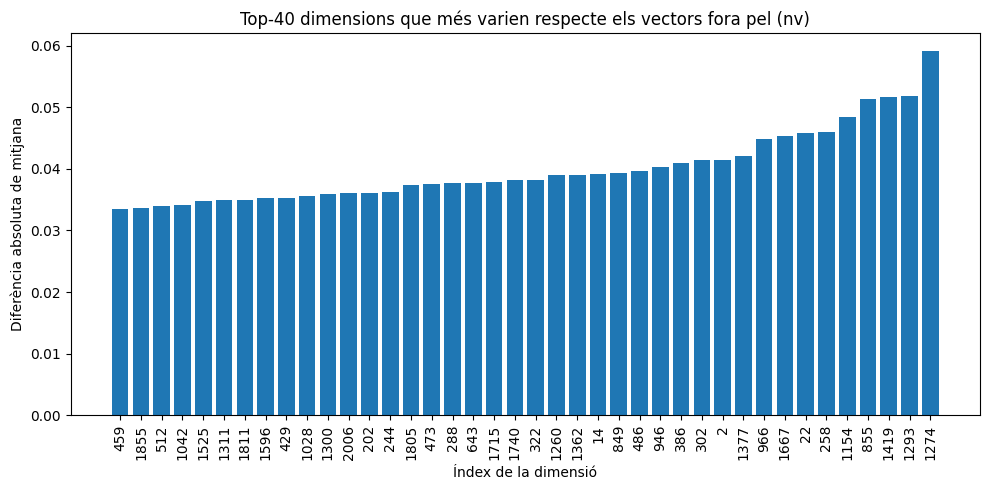

In [ ]:

# Selecciona les top-20 diferències més grans
top_k = 40
classe = "nv"  # Assegura’t que la variable `classe` té aquest valor
top_diff_indices = np.argsort(class_feature_diffs[classe])[-top_k:]

# Visualitza-les
plt.figure(figsize=(10, 5))
plt.bar(range(top_k), class_feature_diffs[classe][top_diff_indices])
plt.xticks(range(top_k), top_diff_indices, rotation=90)
plt.title(f"Top-{top_k} dimensions que més varien respecte els vectors fora pel ({classe})")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Diferència absoluta de mitjana")
plt.tight_layout()
plt.show()

In [ ]:
# for i in top_indices2:
#   if i not in top_indices1:
#     print(i)

mel: 1042, 165, 1429, 1418 \\
nv: 1042, 165, 1429, 1219 \\
bkl: 1117,1219,262,781 \\
vasc: 165, 1429, 438, 862 \\
bcc: 781, 262, 1117, 1429 \\



In [ ]:
# print(metadates)
# diagnosis = metadates.loc[metadates['dx'] == 'mel', 'image_id'].values
# print(diagnosis)

In [ ]:

# for path in IMAGE_PATHS:  # Puedes cambiar el número de imágenes que deseas ver
#     img = Image.open(path)
#     clear_output(wait=True)  # Limpia la celda para mostrar la siguiente imagen
#     display(img)
#     print(path)
#     time.sleep(3)  # Espera 2 segundos


In [ ]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# print(vector_features)